Kai-Yanna Meighu
20590232

Enter your desired mode (default | constant | relax | sin): default


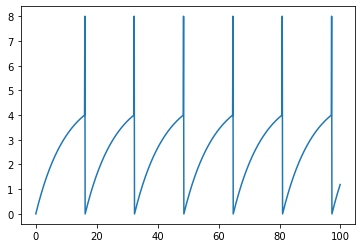

Enter your desired mode (default | constant | relax | sin): constant
Enter the amount of current you would like to inject at each time step: 3
Enter the threshold value for this neuron.: 2


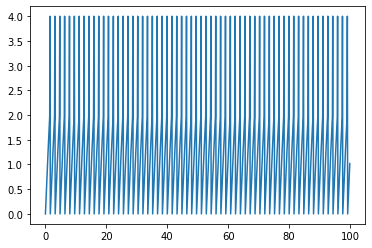

Enter your desired mode (default | constant | relax | sin): relax
Enter the amount of current you would like to inject at each time step: 1
Enter the threshold value for this neuron.: 3


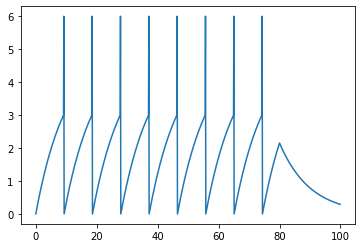

Enter your desired mode (default | constant | relax | sin): sin
Enter the threshold value for this neuron.(For this mode, a value between 0.2 and 0.5 is recommended): 0.3


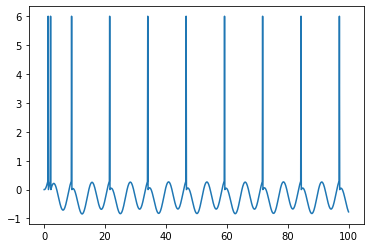

Enter your desired mode (default | constant | relax | sin): quit
Sorry, I don't understand that mode!
Try:
"default"  for a constant current of 1 and a threshold of 4
"constant" for constant current injection of your choosing
"relax"    for constant current injection of your choosingwith a natural relax after 800 time steps
"sin"      for sinsusoidally modelled current injection

Enter your desired mode (default | constant | relax | sin): 
Sorry, I don't understand that mode!
Try:
"default"  for a constant current of 1 and a threshold of 4
"constant" for constant current injection of your choosing
"relax"    for constant current injection of your choosingwith a natural relax after 800 time steps
"sin"      for sinsusoidally modelled current injection

Enter your desired mode (default | constant | relax | sin): q
Sorry, I don't understand that mode!
Try:
"default"  for a constant current of 1 and a threshold of 4
"constant" for constant current injection of your choosing
"relax"    for 

In [ ]:
%matplotlib inline

import math
import matplotlib.pyplot as p

from enum import Enum
/s
# Constants
time_step  = 0.1  # Magnitude of single time step
time       = [i * time_step for i in range(0, 1000)] # List of times to iterate through and plot as y axis
resistance = 5
tau        = 10
voltage    = [0] # voltage[i] is the voltage of the neuron at the corresponding time time[i]
# For relax mode, we will need to use this to stop injecting current at the 800th timestep
current_interval_for_relax = (0, 80)

"""
Enum to define the modes that this program supports:
DEFAULT: Model a neuron that has a constant current injection of 1 and a spiking threshold of 4
CONSTANT: Model a neuron with a constant current injection defined by the user and a spiking threshold
    defined by the user
NATURAL_RELAX: Model a neuron with constant, user-defined current injection and user-defined
    threshold until the 800th time step. After the 800th time step, let the neuron naturally relax to
    resting potential.
SINUSOIDAL: Model a neuron with a sinsusoidally modelled current injection and user-defined threshold.
    For this mode, the threshold should lie between 0.2 and 0.5 to get a good visualization of
    spiking behaviour (due to constants tau, resistance and starting voltage).
"""
class Modes(Enum):
    DEFAULT       = "default"
    CONSTANT      = "constant"
    NATURAL_RELAX = "relax"
    SINUSOIDAL    = "sin"

# Helper function to get a dynamic threshold for best visualization. In the case of the
# sinusodial current, spikes occur at such a low value, we should scale the threshold by 20
# to get the best graph. In other cases, twice the threshold should be sufficient
def getSpikeDisplay(mode, threshold):
    if mode == Modes.SINUSOIDAL:
        return 20 * threshold
    return 2 * threshold

# Helper function to get the current that should be injected into the neuron at time, time
def getCurrent(*, time, value=1, mode=Modes.CONSTANT):
    if mode in [Modes.DEFAULT, Modes.CONSTANT] :
        return value
    elif mode == Modes.NATURAL_RELAX:
        if time < current_interval_for_relax[1]:
            return value
        else:
            return 0
    elif mode == Modes.SINUSOIDAL:
        return math.sin(time)

# Helper function to get the new voltage based on our equation. The voltage at time t is the voltage
# at time t-1 plus the change in voltage as a function of the time delta.
def newVal(old_value, dvdt, dt):
    return old_value + (dt * dvdt)

# Helper function to get the rate of change of voltage
def dvdt(tau, resistance, voltage, current):
    return ((resistance * current) - voltage)/tau

# Function that calculates the voltage for each time step and then produces the required plot
# of voltage vs time.
def model(mode, current_value, threshold):
    # Get the value we tack on for good displays of spikes
    spikeDisplay = getSpikeDisplay(mode, threshold)

    for j in time:
        curCur = getCurrent(time=j, value=current_value, mode=mode) # How much current are we injecting?
        changeInV = dvdt(tau, resistance, voltage[-1], curCur) # How is our voltage changing over time
        newV = newVal(voltage[-1], changeInV, time_step) # What is the new voltage at the current time?

        relaxing = True if (j > current_interval_for_relax[1] and mode == Modes.NATURAL_RELAX) else False

        # If we've just spiked, we need to reset the voltage to 0, unless we are allowing the
        # neuron to relax naturally
        if voltage[-1] == spikeDisplay:
            if not relaxing:
                voltage.append(0)
            else:As said in class, this is an idealized model. Resting potential is 0. Don't try to shoehorn into the physiological numbers. You don't really gain anything useful, but you make it harder to debug. 

You don't want a plot func that is actually running the IandF model unless that is in the name. The names of your functions should communicate what they do.

Also, most critically, I do not believe you are updating your voltage properly. It should be weighted by the time step. 
                voltage.append(newV)
        # If the voltage is above the threshold, spike
        elif newV > threshold:
            voltage.append(spikeDisplay)
        else:
            voltage.append(newV)

    p.plot(time,voltage[0:-1])
    p.show()

# Helper function to get threshold and input current values from the user, looping on invalid
# inputs
def sanitizeInput(*, varName, mode):
    if varName == 'threshold':
        input_string = "Enter the threshold value for this neuron."
        if mode == Modes.SINUSOIDAL:
            input_string += "(For this mode, a value between 0.2 and 0.5 is recommended)"
        input_string += ": "
    elif varName == 'current_value':
        input_string = "Enter the amount of current you would like to inject at each time step: "

    while True:
        value = input(input_string)
        try:
            value = float(value)
            break
        except ValueError as e:
            print(f'That doesn\'t look like a number!')

    return value

if __name__ == "__main__":
    defaultCurrent = 1
    defaultThreshold = 4
    current_value = defaultCurrent

    while True:
        voltage = [0] # For each model, reset the voltages
        while True:
            desired_mode = input("Enter your desired mode (default | constant | relax | sin): ")
            if desired_mode == Modes.DEFAULT.value:
                mode = Modes.DEFAULT
                break
            if desired_mode == Modes.CONSTANT.value:
                mode = Modes.CONSTANT
                current_value = sanitizeInput(varName='current_value', mode=mode)
                break
            elif desired_mode == Modes.NATURAL_RELAX.value:
                mode = Modes.NATURAL_RELAX
                current_value = sanitizeInput(varName='current_value', mode=mode)
                break
            elif desired_mode == Modes.SINUSOIDAL.value:
                mode = Modes.SINUSOIDAL
                break
            else:
                print(f'Sorry, I don\'t understand that mode!\nTry:\n'
                      f'\"{Modes.DEFAULT.value}\"  for a constant current of 1 and a threshold of 4\n'
                      f'\"{Modes.CONSTANT.value}\" for constant current injection of your choosing\n'
                      f'\"{Modes.NATURAL_RELAX.value}\"    for constant current injection of your choosing' 
                      f'with a natural relax after 800 time steps\n'
                      f'\"{Modes.SINUSOIDAL.value}\"      for sinsusoidally modelled current injection\n')


        if mode == Modes.DEFAULT:
            model(mode, defaultCurrent, defaultThreshold)
        else:
            threshold = sanitizeInput(varName='threshold', mode=mode)
            model(mode, current_value, threshold)


*Compare what the firing of your IandF model looks like with a constant current injection, and compare it to what happens to a real neuron (as described here) when given a constant current injection. Does that make the IandF model a "good" or "bad" neural model and why?*

Here is the output of my Integrate and Fire Neuron with a constant input current of 1 and a threshold of 4, for 5000 time steps:
![lots](lots.png)

And 50 trials of a constant input current of 1, threshold of 4 over 2000 time steps"
![50 trials](50trials.png)

Here is the behaviour of a real neuron when given a constant current injection:
![theirs](real.png)

Overall, the behaviour of the modelled neuron is very similar to that of the real neuron. 

We note that many trials of the modelled neuron will produce the exact same spiking pattern, once the resistance and capacitance remain constant. The real neuron, on the other hand, shows some variablity among trials. The article notes that the neuron responds reliably to constant current input with regards to spike count or average firing rate, but, there is volatility in the precise timing of the firings. We are not be able to observe this variance with our model, as the behaviour is deterministic. 

In addition, in this implementation of the IandF model, we manually reset the voltage of the neuron to its resting potential immediately after a spike. Looking at the graph from the article, this does not appear to be the behaviour of the real neuron, as we can see a curve downwards following each curve (as opposed to a jump). 

The article notes that even though precisely timed spiking patterns over multiple trials were produced, only some theories of information processing actually require this behaviour. In other words, we are unsure of the physiological significance of precise spike timings. As such, this difference does not indicate a "bad" model. The disagreement between our model and the real neuron may be important, but it also may not affect the study at all. In my opinion, the IandF model seems to provide an accurate look at the behaviour of a neuron. It is a simple starting point that illustrates fundamental concepts well, though it may not be suitable for every study. 